In [539]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [540]:
import pandas as pd
import matplotlib as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report
import shap
from sklearn.inspection import permutation_importance

In [541]:
# load the initial labeled data:
initial_data = pd.read_csv("02 CHDdata-sample-to-start-with.csv")
# load the unlabeled data:
unlabeled_data = pd.read_csv("03 CHDdata-unlabelled-nolabels.csv", sep=';')
orderlist = unlabeled_data.copy()

In [542]:
#getting an overview over what the data looks like
initial_data.head(10)


,chd,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age
0,0,143,5.04,4.86,23.59,Absent,58,24.69,18.72,42
1,1,136,2.52,3.95,25.63,Absent,51,21.86,0.00,45
2,1,136,11.20,5.81,31.85,Present,75,27.68,22.94,58
3,0,144,2.40,8.13,35.61,Absent,46,27.38,13.37,60
4,0,153,7.80,3.96,25.73,Absent,54,25.91,27.03,45
5,0,128,0.73,3.97,23.52,Absent,54,23.81,19.20,64
6,0,132,0.00,4.17,36.57,Absent,57,30.61,18.00,49
7,1,122,1.00,5.88,34.81,Present,69,31.27,15.94,40
8,0,170,0.40,4.11,42.06,Present,56,33.10,2.06,57
9,1,140,0.60,5.56,33.39,Present,58,27.19,0.00,55


In [543]:
# preparing the data for XGBoost
initial_data.loc[initial_data["famhist"] == "Absent", "famhist"] = 0
initial_data.loc[initial_data["famhist"] == "Present", "famhist"] = 1
initial_data['famhist'] = initial_data['famhist'].astype(int)
initial_data.head(10)



,chd,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age
0,0,143,5.04,4.86,23.59,0,58,24.69,18.72,42
1,1,136,2.52,3.95,25.63,0,51,21.86,0.00,45
2,1,136,11.20,5.81,31.85,1,75,27.68,22.94,58
3,0,144,2.40,8.13,35.61,0,46,27.38,13.37,60
4,0,153,7.80,3.96,25.73,0,54,25.91,27.03,45
5,0,128,0.73,3.97,23.52,0,54,23.81,19.20,64
6,0,132,0.00,4.17,36.57,0,57,30.61,18.00,49
7,1,122,1.00,5.88,34.81,1,69,31.27,15.94,40
8,0,170,0.40,4.11,42.06,1,56,33.10,2.06,57
9,1,140,0.60,5.56,33.39,1,58,27.19,0.00,55


<Axes: >

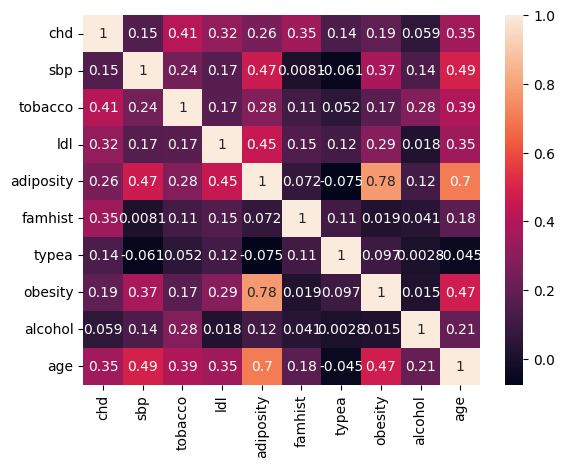

In [544]:
#heatmap of correlations to see whether features are correlated
sns.heatmap(initial_data.corr(), annot= True)

In [545]:
initial_data.dtypes


chd            int64
sbp            int64
tobacco      float64
ldl          float64
adiposity    float64
famhist        int64
typea          int64
obesity      float64
alcohol      float64
age            int64
dtype: object

In [546]:
X = initial_data.drop('chd', axis=1)  # Features
y = initial_data['chd']               # Target

#performing train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [547]:
#fitting XGB Model
model = xgb.XGBClassifier()
model.fit(X_train, y_train)

# predictions for test set
test_predictions = model.predict(X_test)


#Calculating accuracy
accuracy_test = accuracy_score(y_test, test_predictions)

print(f"Test accuracy: {accuracy_test}")

Test accuracy: 0.7368421052631579


In [548]:
# printing the classification report
print("\nClassification Report:")
print(classification_report(y_test, predictions, target_names=['Absent', 'Present']))



Classification Report:
              precision    recall  f1-score   support

      Absent       0.75      0.82      0.78        11
     Present       0.71      0.62      0.67         8

    accuracy                           0.74        19
   macro avg       0.73      0.72      0.72        19
weighted avg       0.73      0.74      0.73        19



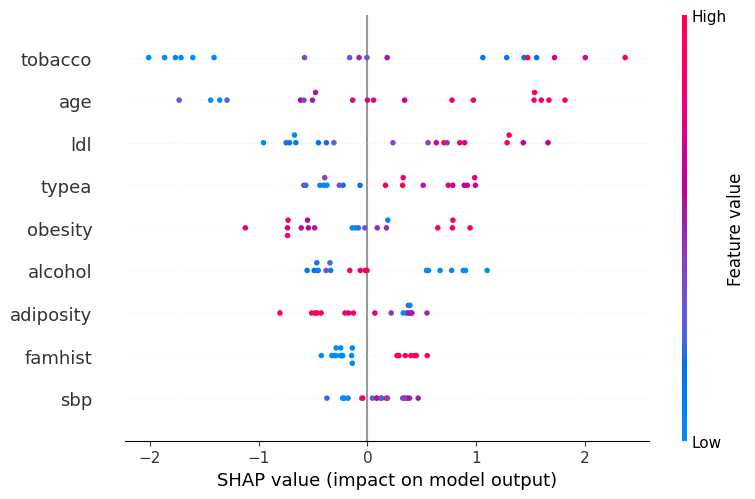

In [549]:
#SHAP Summary Plot

explainer = shap.Explainer(model, X_train)  

# Calculate SHAP values for the test set
shap_values = explainer(X_test)  

shap.summary_plot(shap_values, X_test)

In [550]:
#Permutation Feature Importance


# Calculate permutation feature importance
result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)

# Sort features by importance
sorted_idx = result.importances_mean.argsort()

# Print feature importance
for i in sorted_idx[::-1]:
    print(f"{X_test.columns[i]:<30}"
          f"{result.importances_mean[i]:.3f}"
          f" ± {result.importances_std[i]:.3f}")



tobacco                       0.126 ± 0.067
famhist                       0.063 ± 0.046
obesity                       0.058 ± 0.037
age                           0.058 ± 0.072
alcohol                       0.037 ± 0.024
ldl                           0.011 ± 0.032
adiposity                     0.000 ± 0.000
sbp                           0.000 ± 0.000
typea                         -0.021 ± 0.035


In [551]:
# Predicting probabilities for both the training and test sets
train_probs = model.predict_proba(X)[:, 1]  # Probability of positive class


# Including these probabilities and actual labels in the DataFrames
X['CHD_Probability'] = train_probs
X['chd'] = y.reset_index(drop=True)  # Ensure alignment



# If you want to analyze the performance further, you can, for example,
# inspect cases where the model was highly uncertain:
uncertain_cases = X[(X['CHD_Probability'] > 0.20) & (X['CHD_Probability'] < 0.8)]
uncertain_cases['Actual CHD'] = initial_data['chd']
print(uncertain_cases)
print("Uncertain cases in set:", uncertain_cases.shape[0])



    sbp  tobacco   ldl  adiposity  famhist  typea  obesity  alcohol  age  \
0   143     5.04  4.86      23.59        0     58    24.69    18.72   42   
4   153     7.80  3.96      25.73        0     54    25.91    27.03   45   
12  134     0.00  5.90      30.84        0     49    29.16     0.00   55   
28  158     2.60  7.46      34.07        1     61    29.30    53.28   62   

    CHD_Probability  chd  Actual CHD  
0          0.484314    0           0  
4          0.306798    0           0  
12         0.456045    0           0  
28         0.798358    1           1  
Uncertain cases in set: 4


/var/folders/1h/20qwddgj29lghmzyjxl8m6k80000gn/T/ipykernel_38996/3849838848.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uncertain_cases['Actual CHD'] = initial_data['chd']


In [552]:
initial_data_with_predictions = initial_data.copy()

# excluding any target variable
X_initial = initial_data.drop(columns=['chd'], errors='ignore')

initial_predictions = model.predict(X_initial)  
initial_predictions_probabilities = model.predict_proba(X_initial)[:,1]  
# adding the predictions & Actual CHD as new columns to `initial_data`
initial_data_with_predictions['Actual CHD'] = initial_data['chd']
initial_data_with_predictions['Prediction'] = initial_predictions
initial_data_with_predictions['Probability'] = initial_predictions_probabilities


In [553]:
# Identifying misclassified instances
misclassified= initial_data_with_predictions[initial_data_with_predictions["Actual CHD"] != initial_data_with_predictions["Prediction"]]
print("Misclassified instances: ")
print(misclassified)


Misclassified instances: 
    chd  sbp  tobacco   ldl  adiposity  famhist  typea  obesity  alcohol  age  \
18    0  174     9.45  5.13      35.54        0     55    30.71    59.79   53   
40    0  136     1.70  3.53      20.13        0     56    19.44    14.40   55   
44    1  122     4.40  3.18      11.59        1     59    21.94     0.00   33   
49    1  134     1.50  3.73      21.53        0     41    24.70    11.11   30   
55    1  134    10.00  3.79      34.72        0     42    28.33    28.80   52   

    Actual CHD  Prediction  Probability  
18           0           1     0.970697  
40           0           1     0.876631  
44           1           0     0.199559  
49           1           0     0.041123  
55           1           0     0.098069  


In [554]:
false_positives = misclassified[misclassified['Actual CHD']== 0]
false_negatives = misclassified[misclassified['Actual CHD']== 1]

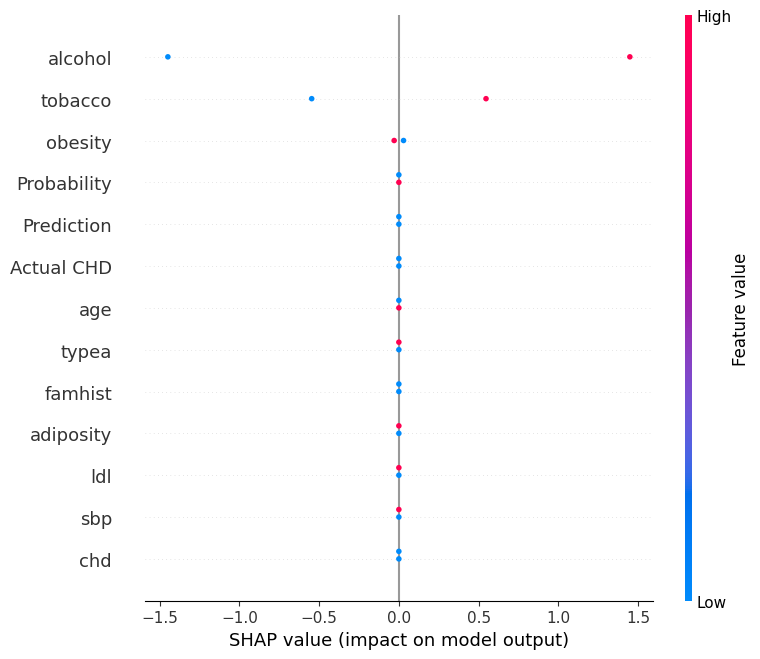

In [555]:
#SHAP Summary Plot

explainer = shap.Explainer(model, false_positives)  

# Calculate SHAP values for the test set
shap_values = explainer(false_positives)  

shap.summary_plot(shap_values, false_positives)

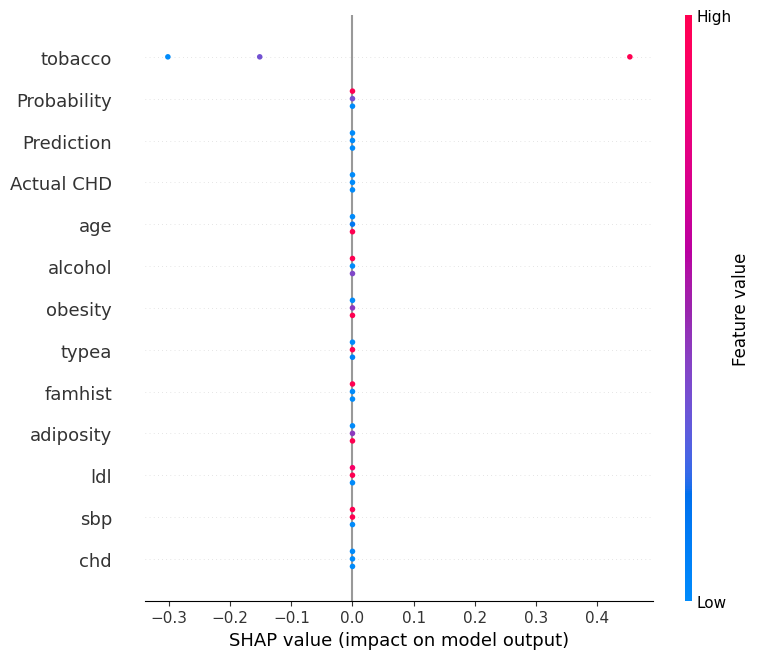

In [556]:
#SHAP Summary Plot

explainer = shap.Explainer(model, false_negatives)  

# Calculate SHAP values for the test set
shap_values = explainer(false_negatives)  

shap.summary_plot(shap_values, false_negatives)

In [557]:
initial_data_with_predictions.describe()


,chd,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,Actual CHD,Prediction,Probability
count,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000
mean,0.365591,139.720430,3.900538,4.700323,26.578817,0.419355,52.129032,26.030323,23.816344,42.978495,0.365591,0.354839,0.367031
std,0.484206,21.446782,4.841627,1.892926,8.433918,0.496128,9.110703,3.856828,31.856970,14.056546,0.484206,0.481058,0.424641
min,0.000000,101.000000,0.000000,1.070000,7.120000,0.000000,31.000000,17.750000,0.000000,15.000000,0.000000,0.000000,0.001174
25%,0.000000,126.000000,0.090000,3.370000,21.530000,0.000000,45.000000,23.330000,0.600000,33.000000,0.000000,0.000000,0.010947
50%,0.000000,134.000000,2.000000,4.170000,27.140000,0.000000,52.000000,25.800000,10.490000,46.000000,0.000000,0.000000,0.084266
75%,1.000000,150.000000,5.500000,5.910000,34.020000,1.000000,58.000000,28.710000,36.000000,54.000000,1.000000,1.000000,0.890669
max,1.000000,218.000000,25.010000,12.420000,42.170000,1.000000,75.000000,35.070000,145.290000,64.000000,1.000000,1.000000,0.997322


In [558]:
false_positives

,chd,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,Actual CHD,Prediction,Probability
18,0,174,9.45,5.13,35.54,0,55,30.71,59.79,53,0,1,0.970697
40,0,136,1.70,3.53,20.13,0,56,19.44,14.40,55,0,1,0.876631


In [559]:
false_negatives

,chd,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,Actual CHD,Prediction,Probability
44,1,122,4.4,3.18,11.59,1,59,21.94,0.00,33,1,0,0.199559
49,1,134,1.5,3.73,21.53,0,41,24.70,11.11,30,1,0,0.041123
55,1,134,10.0,3.79,34.72,0,42,28.33,28.80,52,1,0,0.098069


In [560]:
uncertain_cases

,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,CHD_Probability,chd,Actual CHD
0,143,5.04,4.86,23.59,0,58,24.69,18.72,42,0.484314,0,0
4,153,7.80,3.96,25.73,0,54,25.91,27.03,45,0.306798,0,0
12,134,0.00,5.90,30.84,0,49,29.16,0.00,55,0.456045,0,0
28,158,2.60,7.46,34.07,1,61,29.30,53.28,62,0.798358,1,1
